## Filter Decomposition - Multi Output Regression Approach

### Importing Libraries

In [190]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import os
import pandas as pd
import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt

### Loading Dataset

In [191]:
IMAGE_DIR = '../results/images'
METADATA_PATH = '../results/metadata.csv'
BATCH_SIZE = 32
NUM_FILTERS = 5  # Contrast, Brightness, Saturation, Hue, Exposure
Num_EPOCHS = 10
LR = 0.001

In [192]:
class FilterDataset(Dataset):
    def __init__(self, csv_path, image_dir, transform=None, normalize_intensities=True):
        self.df = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.transform = transform
        self.filter_cols = ['Contrast', 'Brightness', 'Saturation', 'Hue', 'Exposure']  
        self.normalize_intensities = normalize_intensities
        self.max_value = 85.0  
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(os.path.join(self.image_dir, row['Id'])).convert("RGB")
        
        intensities = torch.tensor(row[self.filter_cols].values.astype(np.float32))
        
        if self.normalize_intensities:
            intensities = intensities / self.max_value
        
        if self.transform:
            image = self.transform(image)
        
        return image, intensities

In [193]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = FilterDataset(METADATA_PATH, IMAGE_DIR, transform=transform, normalize_intensities=True)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)


In [ ]:
sample_images, sample_intensities = next(iter(train_loader))
print("Batch images shape:", sample_images.shape)     
print("Batch intensities shape:", sample_intensities.shape)  

Batch images shape: torch.Size([32, 3, 224, 224])
Batch intensities shape: torch.Size([32, 5])


### Model Architecture

In [195]:
class MultiOutputEfficientNet(nn.Module):
    def __init__(self, num_filters=NUM_FILTERS):
        super().__init__()
        self.base_model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        in_features = self.base_model.classifier[1].in_features
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, num_filters)
        )
    
    def forward(self, x):
        return self.base_model(x)

model = MultiOutputEfficientNet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


MultiOutputEfficientNet(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
       

In [196]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                       Param #
MultiOutputEfficientNet                                      --
├─EfficientNet: 1-1                                          --
│    └─Sequential: 2-1                                       --
│    │    └─Conv2dNormActivation: 3-1                        928
│    │    └─Sequential: 3-2                                  1,448
│    │    └─Sequential: 3-3                                  16,714
│    │    └─Sequential: 3-4                                  46,640
│    │    └─Sequential: 3-5                                  242,930
│    │    └─Sequential: 3-6                                  543,148
│    │    └─Sequential: 3-7                                  2,026,348
│    │    └─Sequential: 3-8                                  717,232
│    │    └─Conv2dNormActivation: 3-9                        412,160
│    └─AdaptiveAvgPool2d: 2-2                                --
│    └─Sequential: 2-3                                      

In [ ]:
# save the modal weights
torch.save(model.state_dict(), 'model_weights.pth') 

### Training 

In [198]:
# train setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [199]:
# train loop
train_losses = []
val_losses = []

for epoch in range(Num_EPOCHS):
    model.train()
    running_loss = 0.0

    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in test_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{Num_EPOCHS}]  Train Loss: {avg_train_loss:.4f}  Val Loss: {avg_val_loss:.4f}")


Epoch [1/10]  Train Loss: 0.1032  Val Loss: 0.0882
Epoch [2/10]  Train Loss: 0.0574  Val Loss: 0.0605
Epoch [3/10]  Train Loss: 0.0403  Val Loss: 0.0597
Epoch [4/10]  Train Loss: 0.0313  Val Loss: 0.0523
Epoch [5/10]  Train Loss: 0.0241  Val Loss: 0.0532
Epoch [6/10]  Train Loss: 0.0204  Val Loss: 0.0523
Epoch [7/10]  Train Loss: 0.0190  Val Loss: 0.0458
Epoch [8/10]  Train Loss: 0.0176  Val Loss: 0.0468
Epoch [9/10]  Train Loss: 0.0160  Val Loss: 0.0514
Epoch [10/10]  Train Loss: 0.0154  Val Loss: 0.0452


### Loss and Accuracy Plots

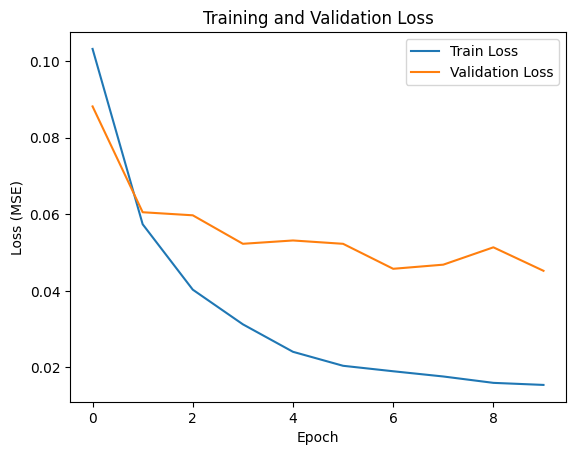

In [200]:
plt.title('Training and Validation Loss')
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

### Evaluation

In [201]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, targets in test_loader:
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)
        y_true.append(targets.cpu().numpy())
        y_pred.append(outputs.cpu().numpy())

y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

filter_names = ['Contrast', 'Brightness', 'Saturation', 'Hue', 'Exposure']

print("\n Metrics:")

for i, name in enumerate(filter_names):
    mse = mean_squared_error(y_true[:, i], y_pred[:, i])
    mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
    r2 = r2_score(y_true[:, i], y_pred[:, i])

    print(f"{name:<12} | MSE: {mse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

# overall R² across all outputs
overall_r2 = r2_score(y_true, y_pred)
print(f"\n Overall R² Score (all filters): {overall_r2:.4f}")



 Metrics:
Contrast     | MSE: 0.0236 | MAE: 0.1158 | R²: 0.6932
Brightness   | MSE: 0.0125 | MAE: 0.0807 | R²: 0.8637
Saturation   | MSE: 0.1047 | MAE: 0.2404 | R²: 0.0874
Hue          | MSE: 0.0541 | MAE: 0.1597 | R²: 0.4275
Exposure     | MSE: 0.0312 | MAE: 0.1314 | R²: 0.6443

 Overall R² Score (all filters): 0.5432
